# Dataloader Setup for Colab Notebooks

In [6]:
# Install Kaggle API
!pip install -q kaggle

In [19]:
# Import libraries
import os
from google.colab import files
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [3]:
# Check if the API key already exists
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print('Please upload your personal kaggle.json file:')

    # Prompt for upload
    uploaded = files.upload()

    # Move the file to the correct directory
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print('\nKaggle API key configured successfully.')
else:
    print('Kaggle API key is already configured.')

Please upload your personal kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API key configured successfully.


In [4]:
# Replace with your dataset id here
KAGGLE_DATASET_ID = 'andymalinsky/rsna-2022-hdf5-subset'

print('Downloading dataset...')
!kaggle datasets download -d {KAGGLE_DATASET_ID}

Dataset URL: https://www.kaggle.com/datasets/andymalinsky/rsna-2022-hdf5-subset
License(s): CC0-1.0
100% 3.51G/3.51G [00:40<00:00, 262MB/s]
100% 3.51G/3.51G [00:40<00:00, 92.9MB/s]


In [5]:
# Unzip and move to the local Colab storage for training
zip_name = KAGGLE_DATASET_ID.split('/')[-1] + '.zip'
!unzip -q '{zip_name}'

# This is the path the training script will use
HDF5_FILE_PATH = '/content/fracture_dataset_subset.h5'

In [17]:
# Get dataloader script from GitHub
!wget https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py

--2025-11-19 14:26:18--  https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917 (5.8K) [text/plain]
Saving to: ‘dataloader.py’

dataloader.py       100%[===================>]   5.78K  --.-KB/s    in 0s      

2025-11-19 14:26:18 (75.2 MB/s) - ‘dataloader.py’ saved [5917/5917]



In [18]:
# Import dataloader script
from dataloader import get_dataloaders

In [20]:
# View data file
data_path = 'fracture_dataset_subset.h5'

# Open the file
with h5py.File(data_path, 'r') as f:
    # View key list, essentially our 'columns'
    print(f'Keys: {list(f.keys())}')

    # View column shapes
    print('\n--- Details ---')
    for key in f.keys():
        dataset = f[key]
        print(f'\nKey: {key}')
        print(f'Shape: {dataset.shape}')
        print(f'Dtype: {dataset.dtype}')

Keys: ['SliceNumber', 'StudyInstanceUID', 'bboxes', 'images', 'labels', 'split']

--- Details ---

Key: SliceNumber
Shape: (28868,)
Dtype: object

Key: StudyInstanceUID
Shape: (28868,)
Dtype: object

Key: bboxes
Shape: (28868, 10, 4)
Dtype: float32

Key: images
Shape: (28868, 256, 256)
Dtype: float32

Key: labels
Shape: (28868,)
Dtype: int8

Key: split
Shape: (28868,)
Dtype: int8


In [21]:
# View the first sample data
with h5py.File(data_path, 'r') as f:
    slice_number = f['SliceNumber'][0]
    study_instance_uid = f['StudyInstanceUID'][0]
    bbox = f['bboxes'][0]
    image = f['images'][0]
    label = f['labels'][0]
    split = f['split'][0]

print(f'SliceNumber: {slice_number}')
print(f'StudyInstanceUID: {study_instance_uid}')
print(f'Boxes: {bbox} (-1 is padding, which means no box)')
print(f'Image shape: {image.shape}')
print(f'Label: {label} (0=no fracture, 1=fracture)')
print(f'Split: {split} (0=train, 1=validation, 2=test)')

SliceNumber: b'59'
StudyInstanceUID: b'1.2.826.0.1.3680043.14345'
Boxes: [[-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]] (-1 is padding, which means no box)
Image shape: (256, 256)
Label: 0 (0=no fracture, 1=fracture)
Split: 0 (0=train, 1=validation, 2=test)


In [22]:
# Define visualizer function
def visualize_samples(num_samples, label):
    with h5py.File(data_path, 'r') as hf:
        # Load all labels and find the indices for the desired sample type
        all_labels = hf['labels'][:]
        indices_to_sample_from = np.where(all_labels == label)[0]
        sample_indices = random.sample(list(indices_to_sample_from), num_samples)
        fig, axes = plt.subplots(1, num_samples, figsize=(10, 10))

        for ax, idx in zip(axes, sample_indices):
            # Load the data for this one sample
            image = hf['images'][idx]
            bboxes = hf['bboxes'][idx]
            uid = hf['StudyInstanceUID'][idx]
            slice_num = hf['SliceNumber'][idx]
            label = hf['labels'][idx]

            # Filter out the "-1" padding on the bounding boxes
            bboxes = [box for box in bboxes if box[0] != -1.0]

            # Plot the image
            ax.imshow(image, cmap='bone')
            # Set title
            ax.set_title(f'Negative Sample (Label: {label}) \nSlice: {slice_num} | (Index: {idx})')

            # Plot each bounding box
            for box in bboxes:
                x, y, w, h = box # the box value contains its coordinates and dimensions

                # Draw the bounding box on the image
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

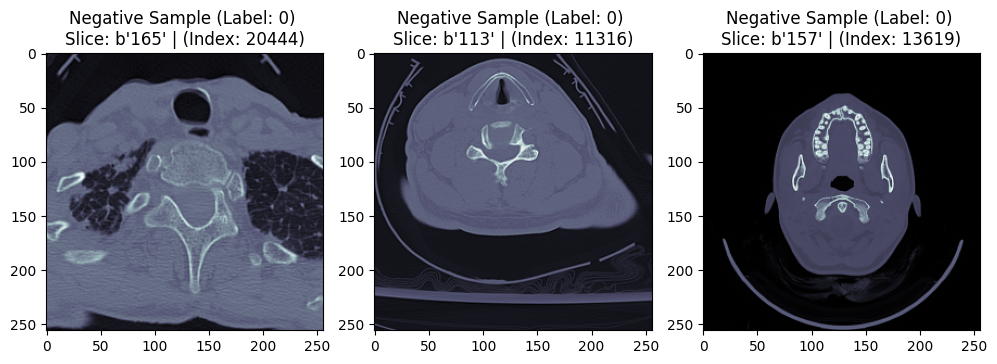

In [23]:
# View 3 sample negative images
visualize_samples(3, 0)

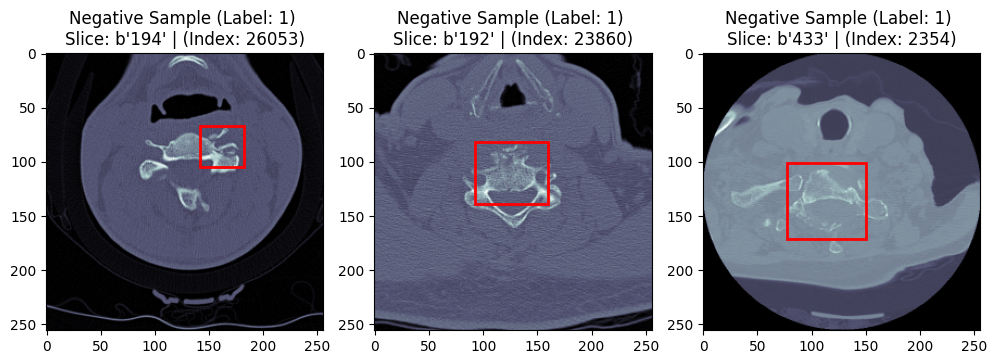

In [24]:
# View 3 sample positive images
visualize_samples(3, 1)

## Classification Dataloaders
* Returns: (images, labels)
* Images: A single tensor: [BatchSize, 1, 256, 256]
* Labels: A single tensor: [BatchSize] (with values 0 or 1)

In [25]:
# Get data loaders for classification
batch_size = 32

train_loader_cls, val_loader_cls, test_loader_cls = get_dataloaders(
    hdf5_path=data_path,
    batch_size=batch_size,
    task='classification'
)

Loading dataset for task: 'classification'...
Loading pre-defined train/val/test splits...
Total samples: 28868
  Training indices:   20207
  Validation indices: 4330
  Test indices:       4331
DataLoaders created successfully.


## Detection Dataloaders
* Returns: (images, targets)
* Images: A list of image tensors (length BatchSize)
* Targets: A list of target dictionaries (length BatchSize)

In [26]:
# Get data loaders for detection
batch_size = 8 # lower batch size since detection models need more memory

train_loader_det, val_loader_det, test_loader_det = get_dataloaders(
    hdf5_path=data_path,
    batch_size=batch_size,
    task='detection'
)

Loading dataset for task: 'detection'...
Loading pre-defined train/val/test splits...
Total samples: 28868
  Training indices:   20207
  Validation indices: 4330
  Test indices:       4331
DataLoaders created successfully.


## Use the Dataloaders for Model Training and Evaluation
1. Get the dataloaders for your task (classification vs detection)
2. Define your model
3. Perform training loop
   * Load images in batches "for images, labels in tqdm(train_loader_cls, desc='Training Batch'):"